In [1]:
# Load datasets from saved pickle files
import pandas as pd
import os

import os, json, pickle, random, time

import xgboost as xgb
import numpy as np
from sklearn.preprocessing    import LabelEncoder
from sklearn.metrics          import (
    precision_recall_curve, auc,
    accuracy_score
)

from sklearn.utils import compute_sample_weight



In [2]:
import os
import pickle
import random
import time
import json

import numpy as np
import xgboost as xgb

from sklearn.preprocessing    import LabelEncoder
from sklearn.metrics          import f1_score, classification_report
from sklearn.model_selection  import StratifiedKFold
from sklearn.utils            import compute_sample_weight

# ————————————————————————————————————————————————
def load_history(path):
    if os.path.exists(path):
        return pickle.load(open(path, 'rb'))
    return {
        'tried_params': {},
        'best': {
            'params':          None,
            'f1_val':          0.0,    # CV macro-F1 on training
            'threshold':       0.5,    # chosen threshold from validation
            'f1_val_thresh':   0.0,    # macro-F1 on validation at that threshold
            'f1_test':         0.0,    # macro-F1 on test at that threshold
            'model_path':      None
        }
    }

def save_history(history, path):
    d = os.path.dirname(path)
    if d and not os.path.exists(d):
        os.makedirs(d, exist_ok=True)
    pickle.dump(history, open(path, 'wb'))

def sample_params(space):
    return {
        'n_estimators':         random.randint(*space['n_estimators']),
        'learning_rate':        random.uniform(*space['learning_rate']),
        'max_depth':            random.randint(*space['max_depth']),
        'subsample':            random.uniform(*space['subsample']),
        'colsample_bytree':     random.uniform(*space['colsample_bytree']),
        'objective':            'binary:logistic',
        'eval_metric':          'aucpr',      # we keep AUCPR for early stopping
        'random_state':         42,
        'early_stopping_rounds': 50
    }

def cv_macro_f1(params, X, y, sw, n_splits=5):
    """
    Returns the mean of each fold's best‐possible macro-F1, where
    each fold is allowed to sweep threshold from 0.01 to 0.99.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_scores = []

    # We'll search thresholds in [0.01, 0.99]
    thresh_candidates = np.arange(0.01, 1.00, 0.01)

    for tr_idx, val_idx in skf.split(X, y):
        # 1) Split for this fold
        X_tr_fold, X_val_fold = X[tr_idx], X[val_idx]
        y_tr_fold, y_val_fold = y[tr_idx], y[val_idx]
        sw_tr_fold, sw_val_fold = sw[tr_idx], sw[val_idx]

        # 2) Train the XGBoost model on the training fold
        model = xgb.XGBClassifier(**params)
        model.fit(
            X_tr_fold,
            y_tr_fold,
            sample_weight = sw_tr_fold,
            eval_set = [(X_val_fold, y_val_fold)],
            sample_weight_eval_set = [sw_val_fold],
            verbose=False
        )

        # 3) Get probabilities on that fold's hold-out
        proba_val_fold = model.predict_proba(X_val_fold)[:, 1]

        # 4) Sweep thresholds to pick best macro-F1 for this fold
        best_fold_f1 = 0.0
        for t in thresh_candidates:
            preds_t = (proba_val_fold >= t).astype(int)
            fold_f1 = f1_score(y_val_fold, preds_t, average='macro')
            if fold_f1 > best_fold_f1:
                best_fold_f1 = fold_f1

        # 5) Record the best macro-F1 for this fold
        fold_scores.append(best_fold_f1)

    # 6) Return the mean across folds
    return np.mean(fold_scores)


def random_search_xgb_macro_f1(
    X_train, y_train,
    X_val,   y_val,
    X_test,  y_test,
    param_space,
    results_path,
    best_model_bin
):
    history = load_history(results_path)

    # Convert inputs to numpy arrays if they're DataFrames
    X_train = np.asarray(X_train)
    X_val   = np.asarray(X_val)
    X_test  = np.asarray(X_test)

    # --- Encode once ---
    le     = LabelEncoder().fit(y_train)
    y_tr   = le.transform(y_train)
    y_vale = le.transform(y_val)
    y_te   = le.transform(y_test)

    # --- Compute sample weights (balanced) ---
    sw_tr  = compute_sample_weight('balanced', y_tr)
    sw_val = compute_sample_weight('balanced', y_vale)

    iteration = 0
    try:
        while True:
            iteration += 1
            params = sample_params(param_space)
            key = json.dumps(params, sort_keys=True)
            if key in history['tried_params']:
                continue

            # (A) 5‐fold CV macro-F1 (each fold does its own threshold sweep)
            f1_val = cv_macro_f1(params, X_train, y_tr, sw_tr, n_splits=5)

            # (B) Now train on the FULL training set, early‐stop on VAL (AUCPR)
            model = xgb.XGBClassifier(**params)
            model.fit(
                X_train, y_tr,
                sample_weight = sw_tr,
                eval_set = [(X_val, y_vale)],
                sample_weight_eval_set = [sw_val],
                verbose=False
            )

            # (C) Find the single best threshold on VALIDATION to maximize macro-F1
            val_probs = model.predict_proba(X_val)[:, 1]
            best_thresh = 0.5
            best_f1_val_thresh = 0.0
            for t in np.arange(0.01, 1.00, 0.01):
                val_preds_t = (val_probs >= t).astype(int)
                f1_val_t = f1_score(y_vale, val_preds_t, average='macro')
                if f1_val_t > best_f1_val_thresh:
                    best_f1_val_thresh = f1_val_t
                    best_thresh = t

            # (D) Compute macro-F1 on TEST using that best_thresh
            test_probs = model.predict_proba(X_test)[:, 1]
            test_preds = (test_probs >= best_thresh).astype(int)
            f1_test = f1_score(y_te, test_preds, average='macro')

            # Record the run in history
            history['tried_params'][key] = {
                'f1_val':          f1_val,
                'threshold':       best_thresh,
                'f1_val_thresh':   best_f1_val_thresh,
                'f1_test':         f1_test,
                'time':            time.time()
            }

            # (E) Update best if either (i) CV score improved or (ii) tie and test improved
            best = history['best']
            better_f1_val     = f1_val > best['f1_val']
            tie_f1_val        = np.isclose(f1_val, best['f1_val'])
            better_f1_test    = f1_test > best.get('f1_test', 0.0)
            not_worse_f1_test = f1_test >= best.get('f1_test', 0.0)

            if (better_f1_val and not_worse_f1_test) or (tie_f1_val and better_f1_test):
                history['best'] = {
                    'params':         params,
                    'f1_val':         f1_val,
                    'threshold':      best_thresh,
                    'f1_val_thresh':  best_f1_val_thresh,
                    'f1_test':        f1_test,
                    'model_path':     best_model_bin
                }
                os.makedirs(os.path.dirname(best_model_bin) or '.', exist_ok=True)
                model.save_model(best_model_bin)

                # Print classification report on TEST at that best threshold
                cr = classification_report(
                    y_te,
                    test_preds,
                    target_names=le.classes_,
                    digits=4
                )

                print(f"[Iter {iteration}] 🎉 New best cv_macro_f1={f1_val:.4f}, "
                      f"val_macro_f1_at_thresh={best_f1_val_thresh:.4f}, "
                      f"test_macro_f1={f1_test:.4f}")
                print("            params =", params)
                print(f"            best threshold = {best_thresh:.2f}\n")
                print("=== Classification Report on TEST ===")
                print(cr)

            save_history(history, results_path)

    except KeyboardInterrupt:
        save_history(history, results_path)
        b = history['best']
        print("\n🔸 Interrupted — best so far:")
        print(f"   f1_val           = {b['f1_val']:.4f}")
        print(f"   threshold (val)  = {b['threshold']:.2f}")
        print(f"   f1_val_thresh    = {b['f1_val_thresh']:.4f}")
        print(f"   f1_test          = {b['f1_test']:.4f}")
        print(f"   params           = {b['params']}")
        print(f"   model            = {b['model_path']}")

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing        import LabelEncoder
from sklearn.metrics              import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    precision_recall_curve,
    roc_curve,
    auc,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.calibration          import CalibratedClassifierCV

def evaluate_with_auto_threshold(
    model,
    X_train, y_train,
    X_val,   y_val,
    X_test,  y_test,
    calibrate: bool = False,
    calibrator_method: str = 'sigmoid'
):
    """
    1) Fit LabelEncoder on y_train.
    2) (Optional) Calibrate model on (X_val, y_val).
    3) Find threshold on val that maximizes MACRO-F1.
    4) Print metrics & classification reports for Val & Test at that threshold.
    5) Plot ROC, PR, Confusion Matrices, Importances.
    """

    # --- STEP 1: Encode labels ---
    le = LabelEncoder().fit(y_train)
    y_val_enc  = le.transform(y_val)
    y_test_enc = le.transform(y_test)

    # --- STEP 2: (Optional) Calibrate on Validation, if requested ---
    if calibrate:
        calibrator = CalibratedClassifierCV(
            estimator=model, method=calibrator_method, cv='prefit'
        )
        calibrator.fit(X_val, y_val_enc)
        proba_val  = calibrator.predict_proba(X_val)[:, 1]
        proba_test = calibrator.predict_proba(X_test)[:, 1]
    else:
        proba_val  = model.predict_proba(X_val)[:, 1]
        proba_test = model.predict_proba(X_test)[:, 1]

    # --- STEP 3: Find best threshold on VAL to maximize MACRO-F1 ---
    thresholds = np.linspace(0.01, 0.99, 99)  # exclude extremes 0.0/1.0 for stability
    best_macro_f1 = -1.0
    best_threshold = 0.50

    for t in thresholds:
        val_preds_t = (proba_val >= t).astype(int)
        # ← Use average='macro' here so that LVOT and RVOT count equally
        macro_f1_val_t = f1_score(y_val_enc, val_preds_t, average='macro')
        if macro_f1_val_t > best_macro_f1:
            best_macro_f1 = macro_f1_val_t
            best_threshold = t

    print(f"\n→ Selected threshold = {best_threshold:.2f}  (Val MACRO-F1 = {best_macro_f1:.4f})\n")

    # --- STEP 4: Helper to print metrics & report at best_threshold ---
    def print_metrics_and_report(y_true_enc, proba, split_name):
        y_pred = (proba >= best_threshold).astype(int)

        # 1) Compute macro metrics
        acc     = accuracy_score(y_true_enc, y_pred)
        prec    = precision_score(y_true_enc, y_pred, average='macro')
        rec     = recall_score(y_true_enc, y_pred, average='macro')
        f1      = f1_score(y_true_enc, y_pred, average='macro')
        rocauc  = roc_auc_score(y_true_enc, proba)
        pr_auc  = auc(*precision_recall_curve(y_true_enc, proba)[:2][::-1])

        print(f"=== {split_name} @ threshold {best_threshold:.2f} ===")
        print(f"  Macro Accuracy : {acc:.4f}")
        print(f"  Macro Precision: {prec:.4f}")
        print(f"  Macro Recall   : {rec:.4f}")
        print(f"  Macro F1-Score : {f1:.4f}")
        print(f"  ROC AUC        : {rocauc:.4f}")
        print(f"  PR AUC         : {pr_auc:.4f}\n")

        # 2) Show per-class precision/recall/F1 (classification_report)
        print("Classification Report (per class):")
        # NOTE: pass le.classes_ so that labels map back to original names (e.g. ['LVOT', 'RVOT'])
        print(classification_report(
            le.inverse_transform(y_true_enc),
            le.inverse_transform(y_pred),
            target_names=le.classes_,
            digits=4
        ))
        print("-" * 60 + "\n")

    # Print VAL metrics/reports
    print_metrics_and_report(y_val_enc, proba_val, "Validation")

    # Print TEST metrics/reports
    print_metrics_and_report(y_test_enc, proba_test, "Test")

    # --- STEP 5: Plots — Confusion Matrix, ROC, PR, Importances ---

    # 5.1 Confusion Matrices (Val & Test)
    for (proba, y_true_enc, split_name) in [
        (proba_val,  y_val_enc,  "Validation"),
        (proba_test, y_test_enc, "Test")
    ]:
        y_pred = (proba >= best_threshold).astype(int)
        cm = confusion_matrix(
            le.inverse_transform(y_true_enc),
            le.inverse_transform(y_pred),
            labels=le.classes_
        )
        disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
        plt.figure(figsize=(5, 5))
        disp.plot(cmap='Blues', ax=plt.gca(), colorbar=False)
        plt.title(f"{split_name} Confusion Matrix (t={best_threshold:.2f})")
        plt.show()

    # 5.2 ROC Curves
    fpr_v, tpr_v, _ = roc_curve(y_val_enc,  proba_val)
    fpr_t, tpr_t, _ = roc_curve(y_test_enc, proba_test)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr_v, tpr_v, label=f"Val ROC (AUC={roc_auc_score(y_val_enc, proba_val):.3f})")
    plt.plot(fpr_t, tpr_t, label=f"Test ROC (AUC={roc_auc_score(y_test_enc, proba_test):.3f})")
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend(loc='lower right')
    plt.show()

    # 5.3 Precision–Recall Curves
    prec_v, rec_v, _ = precision_recall_curve(y_val_enc,  proba_val)
    prec_t, rec_t, _ = precision_recall_curve(y_test_enc, proba_test)
    plt.figure(figsize=(6, 4))
    plt.plot(rec_v, prec_v, label=f"Val PR (AUC={auc(rec_v, prec_v):.3f})")
    plt.plot(rec_t, prec_t, label=f"Test PR (AUC={auc(rec_t, prec_t):.3f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision–Recall Curves")
    plt.legend(loc='lower left')
    plt.show()

    # 5.4 Feature Importances (if using XGBoost)
    try:
        plt.figure(figsize=(8, 6))
        xgb.plot_importance(model, max_num_features=20)
        plt.title("Top 20 Feature Importances")
        plt.show()
    except Exception:
        pass

In [ ]:
# Check if files exist in the outputs directory
if os.path.exists('outputs/X_train_B.pkl'):
    # Load the required datasets for the model training
    X_train_B = pd.read_pickle('outputs/X_train_B.pkl')
    y_train_B = pd.read_pickle('outputs/y_train_B.pkl')
    X_val_B = pd.read_pickle('outputs/X_val_B.pkl')
    y_val_B = pd.read_pickle('outputs/y_val_B.pkl')
    X_test_B = pd.read_pickle('outputs/X_test_B.pkl')
    y_test_B = pd.read_pickle('outputs/y_test_B.pkl')
    
    print(f"Loaded datasets from pickle files:")
    print(f"X_train_B shape: {X_train_B.shape}")
    print(f"X_val_B shape: {X_val_B.shape}")
    print(f"X_test_B shape: {X_test_B.shape}")
    
    PARAM_SPACE = {
        'n_estimators':      (20, 200),
        'learning_rate':     (0.01, 0.3),
        'max_depth':         (2, 30),
        'subsample':         (0.5, 1.0),
        'colsample_bytree':  (0.5, 1.0),
    }

    RESULTS_PICKLE   = "outputs/xgb_macro_f1_search_B.pkl"
    BEST_MODEL_BIN   = "outputs/xgb_macro_f1_best_model_B.bin"
    
    # Now call the random search function with the loaded data
    random_search_xgb_macro_f1(
        X_train_B, y_train_B,
        X_val_B,   y_val_B,
        X_test_B,  y_test_B,
        PARAM_SPACE,
        RESULTS_PICKLE,
        BEST_MODEL_BIN
    )

else:
    print("Error: Dataset files not found in 'outputs/' directory.")
    print("Please ensure you've saved the datasets first using the to_pickle method.")

Loaded datasets from pickle files:
X_train_B shape: (12023, 217)
X_val_B shape: (6454, 217)
X_test_B shape: (6505, 217)


NameError: name 'PARAM_SPACE' is not defined


→ Selected threshold = 0.63  (Val MACRO-F1 = 0.7054)

=== Validation @ threshold 0.63 ===
  Macro Accuracy : 0.8599
  Macro Precision: 0.6925
  Macro Recall   : 0.7222
  Macro F1-Score : 0.7054
  ROC AUC        : 0.8204
  PR AUC         : 0.9657

Classification Report (per class):
              precision    recall  f1-score   support

        LVOT     0.4534    0.5381    0.4921       814
        RVOT     0.9315    0.9064    0.9188      5640

    accuracy                         0.8599      6454
   macro avg     0.6925    0.7222    0.7054      6454
weighted avg     0.8712    0.8599    0.8650      6454

------------------------------------------------------------

=== Test @ threshold 0.63 ===
  Macro Accuracy : 0.8148
  Macro Precision: 0.7410
  Macro Recall   : 0.6875
  Macro F1-Score : 0.7062
  ROC AUC        : 0.8047
  PR AUC         : 0.9288

Classification Report (per class):
              precision    recall  f1-score   support

        LVOT     0.6313    0.4532    0.5276      14

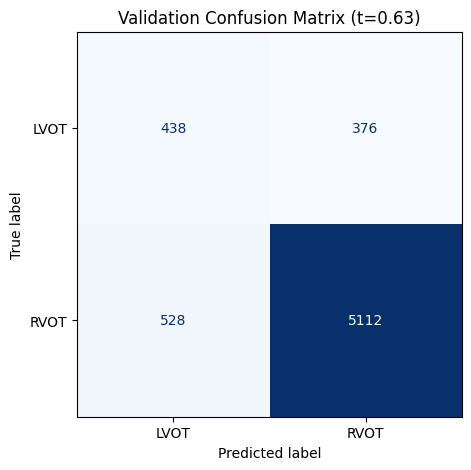

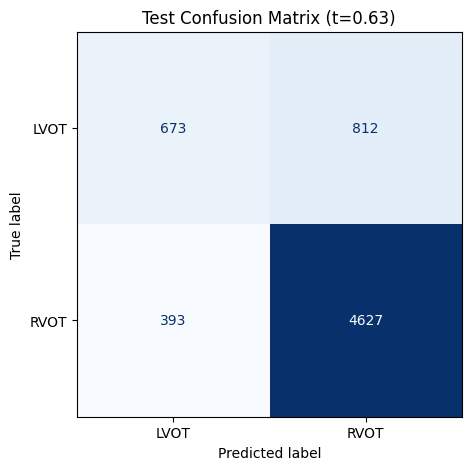

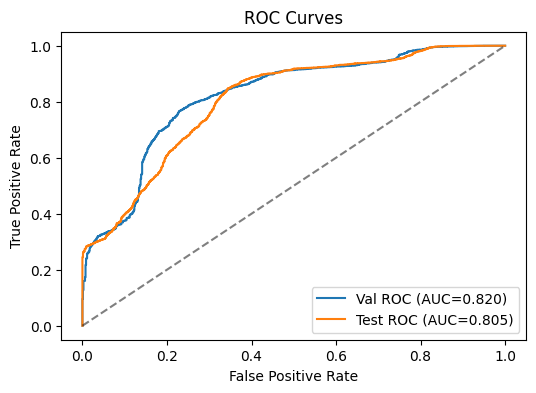

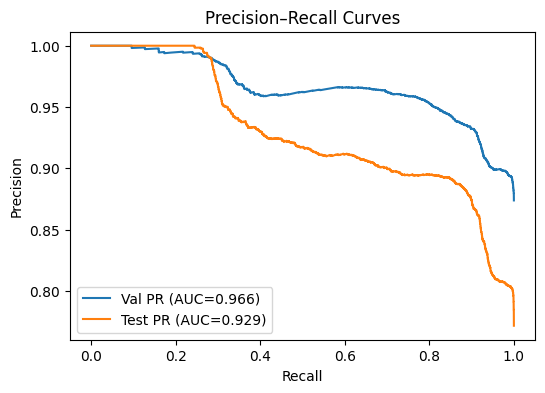

<Figure size 800x600 with 0 Axes>

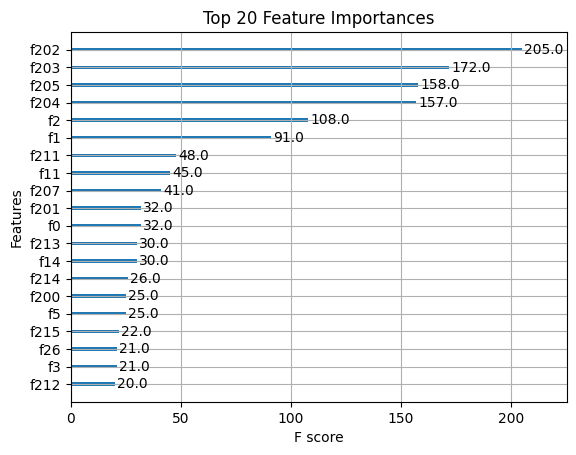

In [ ]:
best_model = xgb.XGBClassifier()
best_model.load_model('outputs/xgb_macro_f1_best_model_B.bin')

evaluate_with_auto_threshold(
    best_model,
    X_train_B, y_train_B,
    X_val_B,   y_val_B,
    X_test_B,  y_test_B,
    calibrate=True,
)

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train_B, y_train_B)
print(classification_report(y_test_B, lr.predict(X_test_B)))